Lors du [billet précédent](http://flothesof.github.io/les-deputes-francais-sont-souvent-absents-aux-scrutins.html), nous avons téléchargé les données globales pour les scrutins de la 14ème législature disponibles sur le site de l'assemblée nationale. Nous en avons conclut qu'en général, les députés ne prenaient pas part aux scrutins. Aujourd'hui, nous allons nous intéresser aux données détaillées disponibles sur le site de l'assemblée, pour répondre à d'autres questions : qui va aux scrutins ? L'absentéisme est-il le fait de tout le monde, ou bien seulement d'une partie des députés ? 

# Téléchargement des données des scrutins 

Pour ce faire, nous allons tout d'abord télécharger les données détaillées disponibles sur chaque page "scrutin". Par exemple : <http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/1238>. Nous stockons ces données dans un dictionnaire indexé par le numéro du scrutin.

In [1]:
import requests

In [2]:
def download_scrutin(num):
    """Télécharge un scrutin en fonction de son numéro."""
    url = "http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/%d"%num
    return requests.get(url).text

In [3]:
# https://www.reddit.com/r/Python/comments/34tdr2/a_simple_progress_bar_for_ipython_notebooks/
from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=100)
display(f)

d = {}
N = 1238
for num in range(1, N + 1):
    f.value = 100 * num / N
    key = str(num)
    if key not in d.keys():
        d[key] = download_scrutin(num)

# Extraction des noms des participants au scrutin

On fait une soupe :

In [4]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(d['1'], 'html.parser')

On cherche tous les noms de députés présents dans la page. Ceux-ci sont répartis par groupes, identifiés par des balises "TTgroupe" :

In [5]:
groups = soup.find_all('div', {"class": "TTgroupe"})

Si on prend le premier groupe et que l'on y cherche toutes les balises "ti", on trouve :

In [6]:
g = groups[0]
g.select('li')[:10]

[<li>            Ibrahim <b>Aboubacar</b></li>,
 <li> Patricia <b>Adam</b></li>,
 <li> Sylviane <b>Alaux</b></li>,
 <li> Jean-Pierre <b>Allossery</b></li>,
 <li> Pouria <b>Amirshahi</b></li>,
 <li> François <b>André</b></li>,
 <li> Sylvie <b>Andrieux</b></li>,
 <li> Nathalie <b>Appéré</b></li>,
 <li> Christian <b>Assaf</b></li>,
 <li> Pierre <b>Aylagas</b></li>]

Bingo ! Ecrivons une fonction pour retourner le nom de tous les députés présents dans le groupe :

In [7]:
def mps_in_group(g):
    """Retourne les noms de tous les députés présents dans un groupe."""
    return [tag.text.strip() for tag in g.select('li')]

In [8]:
mps_in_group(g)[:10]

['Ibrahim\xa0Aboubacar',
 'Patricia\xa0Adam',
 'Sylviane\xa0Alaux',
 'Jean-Pierre\xa0Allossery',
 'Pouria\xa0Amirshahi',
 'François\xa0André',
 'Sylvie\xa0Andrieux',
 'Nathalie\xa0Appéré',
 'Christian\xa0Assaf',
 'Pierre\xa0Aylagas']

On remarque que les noms des députés sont séparés par des [espaces insécables](https://fr.wikipedia.org/wiki/Espace_ins%C3%A9cable), une des particularités de la typographie française.

On peut maintenant extraire la totalité des députés votants à un scrutin à partir de la source du scrutin détaillé.

In [9]:
def all_mps(source):
    """Extrait tous les députés votants lors d'un scrutin."""
    soup = BeautifulSoup(source, 'html.parser')
    groups = soup.find_all('div', {"class": "TTgroupe"})
    all_mps = []
    for g in groups:
        all_mps += mps_in_group(g)
    return all_mps

On peut vérifier que pour le scrutin 1 <http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/1>, le nombre de votants est correct : 

In [10]:
len(all_mps(d['1']))

544

Il semblerait que oui. Nous pouvons maintenant construire un tableau avec la liste des scrutins et les noms des votants.

# Un grand tableau avec pandas 

Les informations essentielles dont nous avons besoin sont les suivantes : 

- numéro du scrutin
- date
- objet
- nombre de votants pour / contre / abstention volontaire
- les noms des députés qui ont exprimé leurs voix

Pour cela, nous reprenons le code du [billet précédent](http://flothesof.github.io/les-deputes-francais-sont-souvent-absents-aux-scrutins.html) et l'enrichissons avec l'extraction que nous venons de développer.

In [11]:
def extract_information(line):
    """Extrait les informations d'une ligne du tableau des scrutins."""
    elems = line.find_all('td')
    # numéro de scrutin
    num = elems[0].text
    # date
    date = elems[1].text
    # objet
    obj = elems[2].text
    # pour
    pour = int(elems[3].text)
    # contre
    contre = int(elems[4].text)
    # abstention
    abstention = int(elems[5].text)
    return num, date, obj, pour, contre, abstention

In [12]:
data = []
for offset in range(0, 1300, 100):
    url = "http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/{}/(legislature)/14/(type)/TOUS/(idDossier)/TOUS".format(offset)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    elems = soup.select('tbody tr')
    data += [extract_information(line) for line in elems]

In [13]:
import pandas as pd

In [14]:
df = pd.DataFrame(data, columns=('numero', 'date', 'objet', 'pour', 'contre', 'abstention'))

In [15]:
day_mapping = {0: '01-lundi', 1: '02-mardi', 2: '03-mercredi', 
               3:'04-jeudi', 4: '05-vendredi', 5: '06-samedi', 6: '07-dimanche'}

In [16]:
df['presents'] = df['pour'] + df['contre'] + df['abstention']
df['absents'] = 577 - df.presents
df.date = pd.to_datetime(df.date, dayfirst=True)
df['jour'] = [day_mapping[date.dayofweek] for date in df.date]
df.numero = df.numero.str.extract('(\d+)')

In [17]:
df.head()

,numero,date,objet,pour,contre,abstention,presents,absents,jour
0,1238,2016-02-16,l'ensemble du projet de loi prorogeant l'appli...,212,31,3,246,331,02-mardi
1,1237,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,567,10,03-mercredi
2,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,146,431,02-mardi
3,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,146,431,02-mardi
4,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,145,432,02-mardi


On va procéder au travail préliminaire pour l'extraction des noms des députés :

Pour chaque scrutin, on procède à l'extraction des noms et on l'insère dans la DataFrame que nous venons de créer.

In [18]:
%%time
df['votants'] = [all_mps(d[num]) for num in df.numero]

Wall time: 1min 1s


In [19]:
df.head()

,numero,date,objet,pour,contre,abstention,presents,absents,jour,votants
0,1238,2016-02-16,l'ensemble du projet de loi prorogeant l'appli...,212,31,3,246,331,02-mardi,"[Jean-Pierre Allossery, François André, Nathal..."
1,1237,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,567,10,03-mercredi,"[Ibrahim Aboubacar, Patricia Adam, Jean-Pierre..."
2,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,146,431,02-mardi,"[Ibrahim Aboubacar, Patricia Adam, Jean-Pierre..."
3,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,146,431,02-mardi,"[Ibrahim Aboubacar, Patricia Adam, Jean-Pierre..."
4,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,145,432,02-mardi,"[Ibrahim Aboubacar, Patricia Adam, Jean-Pierre..."


On peut vérifier que l'extraction est bonne en comparant les nombres de présents avec la longueur de la liste des votants :

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

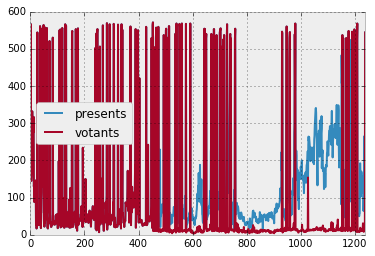

In [21]:
df.presents.plot(legend=True)
df.votants.apply(lambda item: len(item)).plot(legend=True)

Apparemment, il y a des incohérences. On trouve en effet des pages de scrutins pour lesquels les noms des députés ne sont pas connus exactement. Par exemple le scrutin n°2, <http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/2> où de nombreux députés ont délégué leur droit de vote. Ceci fait qu'ils n'apparaissent pas dans les pages à l'endroit habituel.

On va donc garder pour la suite seulement les scrutins pour lesquels les données haut-niveau concordent avec les extractions des noms.

In [22]:
coherent = (df.presents == df.votants.apply(lambda item: len(item)))

In [23]:
coherent.value_counts()

False    708
True     530
dtype: int64

Cela nous laisse un certain nombre de scrutins à analyser.

# Extraction de la présence par député 

On peut analyser les données présentes et extraire le nombre de votes par députés. Tout d'abord, extrayons le nombre de députés uniques trouvés dans les données :

In [24]:
from collections import Counter

In [25]:
c = Counter()
for voting in df[coherent].votants:
    c.update(voting)

In [26]:
len(c)

623

On trouve 623 noms au lieu des 577 que l'on attend. Ceci est sans doute dû au remplacement des députés appelés à d'autres fonctions. On peut trouver un excellent texte sur le site du Monde à ce sujet : <http://www.lemonde.fr/idees/article/2012/07/03/un-depute-suppleant-est-un-representant-a-part-entiere_1728419_3232.html>.

On peut maintenant regarder qui a été le plus souvent là lors des scrutins pris en compte :

In [27]:
df2 = pd.DataFrame(c.most_common(), columns=['depute', 'scrutins'])
df2

,depute,scrutins
0,Gilles Lurton,296
1,Bruno Le Roux,283
2,Marie-Anne Chapdelaine,271
3,Suzanne Tallard,264
4,Dominique Lefebvre,262
5,Gérard Sebaoun,261
6,Bernadette Laclais,260
7,Françoise Descamps-Crosnier,257
8,Jean-Luc Laurent,247
9,Denys Robiliard,246


On peut représenter tout ceci graphiquement :

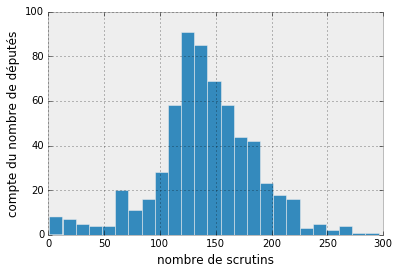

In [28]:
fig, ax = plt.subplots()
df2.scrutins.hist(bins=25)
plt.xlabel('nombre de scrutins')
plt.ylabel('compte du nombre de députés')

Et extraire les statistiques descriptives complètes :

In [29]:
df2.describe()

,scrutins
count,623.000000
mean,140.033708
std,45.680216
min,1.000000
25%,117.000000
50%,139.000000
75%,167.000000
max,296.000000


In [30]:
coherent.value_counts()

False    708
True     530
dtype: int64

La moyenne se situe à 140 scrutins par député, sur 530 scrutins. On retrouve donc là le chiffre d'absentéisme à 3/4 des scrutins, déjà obtenu lors du billet précédent. On constate qu'il y a là une relative homogénéité entre députés, comme le montre l'histogramme précédent : les députés votent en moyennent lors d'un scrutin sur quatre et se comportent un peu comme des variables aléatoires dans le sens où la répartition des votes suit une courbe en cloche. 

On peut s'intéresser aux députés qui votent peu et regarder lors de quels scrutins ils votent. On peut reprendre une visualisation précédente et placer des points plus ou moins gros en fonction du nombre de députés "qui votent peu" présents.

In [31]:
rarely = df2.depute[df2.scrutins < 117] 
often = df2.depute[df2.scrutins > 167] 

J'ai ici choisi les quartiles à 25% et 75% pour la définition des deux groupes de députés.

In [32]:
def marker_size(mp_list, group):
    """Compte le nombre de personnes dans group présent dans la liste mp_list."""
    return len([member for member in mp_list if member in group.values])

On peut tester la fonction sur un seul scrutin :

In [33]:
marker_size(df.ix[0].votants, rarely)

29

In [34]:
marker_size(df.ix[0].votants, often)

81

Et produire des graphiques qui témoignent des comportements :

(-10, 577)

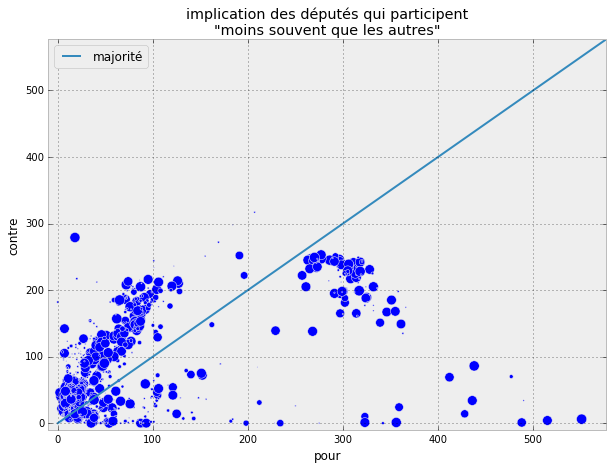

In [35]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot.scatter(ax=ax, x='pour', y='contre', s=[marker_size(v, rarely) for v in df[coherent].votants])
plt.title('implication des députés qui participent\n"moins souvent que les autres"')
plt.plot([0, 577], [0, 577], label='majorité')
plt.legend(loc='upper left')
plt.ylim(-10, 577)
plt.xlim(-10, 577)

(-10, 577)

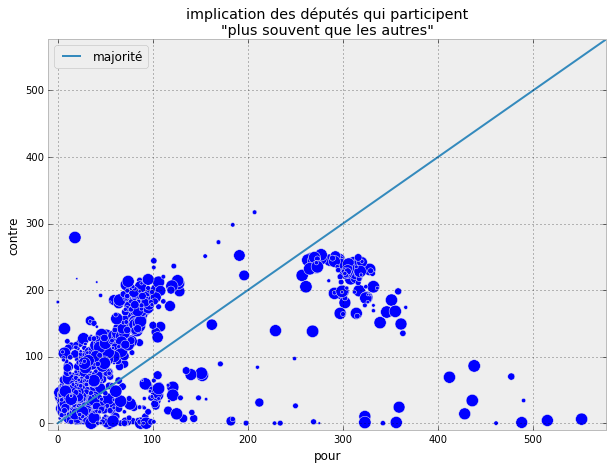

In [36]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot.scatter(ax=ax, x='pour', y='contre', s=[marker_size(v, often) for v in df[coherent].votants])
plt.title('implication des députés qui participent\n"plus souvent que les autres"')
plt.plot([0, 577], [0, 577], label='majorité')
plt.legend(loc='upper left')
plt.ylim(-10, 577)
plt.xlim(-10, 577)

On peut tirer de ces deux graphiques l'interprétation suivante : 

- les députés qui participent moins souvent que les autres ont plutôt tendance à participer aux gros scrutins 
- alors que ceux qui participent plus souvent que les autres participent à tous les scrutins et sont souvent du côté de l'opposition, comme le montre la ligne de séparation de la majorité

Pour mieux mettre en évidence la différence de comportement, on peut représenter en valeur absolue la différence de participation de ces deux groupes de taille comparable :

(-10, 577)

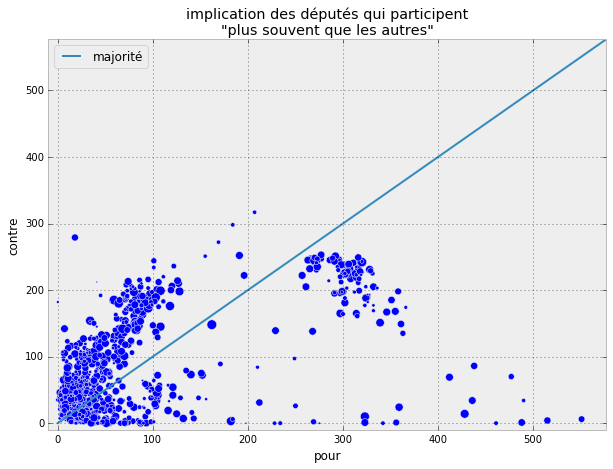

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot.scatter(ax=ax, x='pour', y='contre', s=[abs(marker_size(v, often) - marker_size(v, rarely)) for v in df[coherent].votants])
plt.title('implication des députés qui participent\n"plus souvent que les autres"')
plt.plot([0, 577], [0, 577], label='majorité')
plt.legend(loc='upper left')
plt.ylim(-10, 577)
plt.xlim(-10, 577)

Plus les marqueurs sont gros sur le graphique précédent, plus les scrutins ont été suivis différamments par les députés des deux groupes. Il n'est pas évident de bien voir la différence, mais on remarque que de nombreux "petits scrutins" ont des poids relativement larges dans ce graphique.

# Et ma députée ?  

J'habite actuellement à sommaruga. Je suis représenté par [Julie Sommaruga](http://www2.assemblee-nationale.fr/deputes/fiche/OMC_PA610195) à l'assemblée nationale. Quel comportement Mme Sommaruga adopte-t-elle par rapport aux scrutins ? 

In [38]:
sommaruga = df2.depute[df2.depute.str.contains("Sommaruga")] 

(-10, 577)

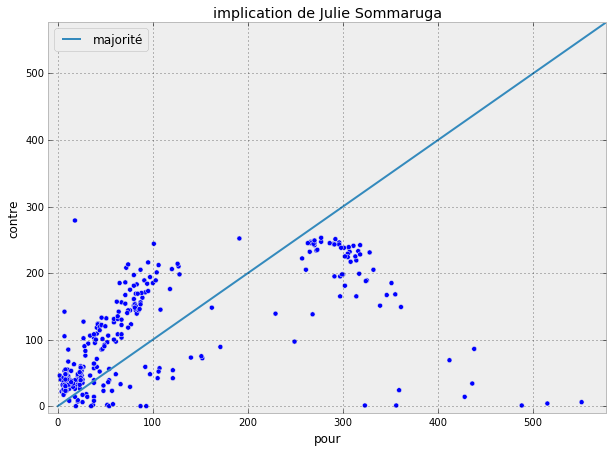

In [39]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot.scatter(ax=ax, x='pour', y='contre', s=[25*marker_size(v, sommaruga) for v in df[coherent].votants])
plt.title('implication de Julie Sommaruga')
plt.plot([0, 577], [0, 577], label='majorité')
plt.legend(loc='upper left')
plt.ylim(-10, 577)
plt.xlim(-10, 577)

On peut remarque Mme Sommaruga participe à des scrutins avec de nombreuses participations ou sans. On peut redessiner ces données sur un seul axe en comptant le nombre de votants total :

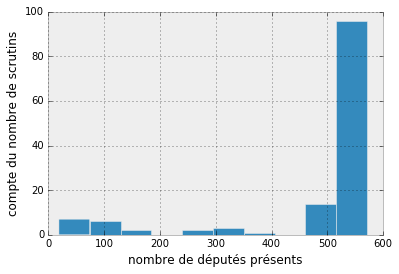

In [40]:
relevant = ['Julie\xa0Sommaruga' in mp for mp in df.votants]
df[relevant].presents.hist()
plt.xlabel('nombre de députés présents')
plt.ylabel('compte du nombre de scrutins')

Ceci conforte l'idée selon laquelle Mme Sommaruga vient principalement assister à des grands scrutins, mais s'investit aussi parfois sur des sujets qui n'attirent pas beaucoup de députés dans l'hémicycle. 

#  Réflexion

Les chiffres de cette étude montrent, comme dans le [billet précédent](http://flothesof.github.io/les-deputes-francais-sont-souvent-absents-aux-scrutins.html), que les députés ne viennent pas souvent prendre part aux scrutins, mis à part les scrutins où ils sont très nombreux. On peut s'interroger sur cette observation. Est-ce un dysfonctionnement de notre système politique ? Ou bien le reflet que de nombreux scrutins ne sont pas forcément pertinents pour tout le monde ? [Julie Sommaruga déclare sur son site public](http://juliesommaruga.fr/le-role-du-depute) que sa vision du député est la suivante : 

> L’Assemblée nationale se situe au cœur de notre démocratie comme le montrent les textes qui régissent le fonctionnement de la Vème République. Représenter les citoyens, légiférer et contrôler l’action du Gouvernement : tel est le triptyque qui guide l’action des 577 députés de la France de métropole et d’Outre-mer.

Au vu des chiffres, présentés ici, on peut dire que l'assemblée ne se situe pas au coeur de la démocratie française, contrairement à ce que pense Mme Sommaruga. Mais quelles raisons poussent les députés à ne pas être présents lors des scrutins ? Ceci reste obscur. En particulier, dans le cadre actuel de l'état d'urgence, il me semble qu'il y a un problème majeur. Cet état, qui tient en haleine le pays depuis les attentats du 13 novembre 2015, a été prolongé lors du scrutin 1238 <http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/1238>. Pourtant, ce scrutin n'a pas vu venir grand monde à l'assemblée : 

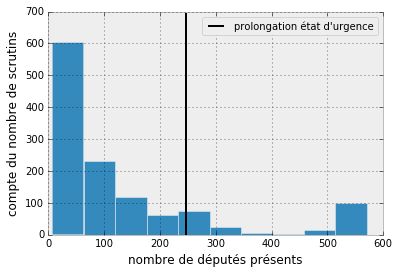

In [41]:
df.presents.hist()
plt.vlines(df[df.numero == '1238'].presents, 0, 700, label="prolongation état d'urgence")
plt.legend(fontsize=10)
plt.xlabel('nombre de députés présents')
plt.ylabel('compte du nombre de scrutins')

Pourquoi ? 